In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import joblib
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# To ignore all warnings
warnings.filterwarnings("ignore")

The original dataset was taken from the following GitHub repository:
https://github.com/Byte7/Solar-Flares-Prediction-RHESSI-Mission/blob/master/data/hessi.solar.flare.2002to2016.csv

In [27]:
df=pd.read_csv("/content/hessi.solar.flare.2002to2016.csv")

# To run in Jupyter Notebook
# df=pd.read_csv("../Dataset/hessi.solar.flare.2002to2016.csv")

DATASET METADATA

In [28]:
'''Notes:
  Note that only events with non-zero position and energy range not equal to 3-6 keV are confirmed as solar sources.
  Events which have no position and show up mostly in the front detectors, but were not able to be imaged
    are flagged as "PS".
  Events which do not have valid position are only confirmed to be non-solar if the NS flag is set.
  Peak Rate:  peak counts/second in energy range 6-12 keV, averaged over active collimators, including background.
  Total Counts:  counts in energy range 6-12 keV integrated over duration of flare summed over all subcollimators,
    including background.
  Energy:  the highest energy band in which the flare was observed.
  Radial Distance:  distance from Sun center
  Quality Codes: Qn, where n is the total number of data gap, SAA, particle, eclipse or decimation flags set for event.
    n ranges from 0 to 11.  Use care when analyzing the data when the quality is not zero.

Flare Flag Codes:
  a0 - In attenuator state 0 (None) sometime during flare
  a1 - In attenuator state 1 (Thin) sometime during flare
  a2 - In attenuator state 2 (Thick) sometime during flare
  a3 - In attenuator state 3 (Both) sometime during flare
  An - Attenuator state (0=None, 1=Thin, 2=Thick, 3=Both) at peak of flare
  DF - Front segment counts were decimated sometime during flare
  DR - Rear segment counts were decimated sometime during flare
  ED - Spacecraft eclipse (night) sometime during flare
  EE - Flare ended in spacecraft eclipse (night)
  ES - Flare started in spacecraft eclipse (night)
  FE - Flare ongoing at end of file
  FR - In Fast Rate Mode
  FS - Flare ongoing at start of file
  GD - Data gap during flare
  GE - Flare ended in data gap
  GS - Flare started in data gap
  MR - Spacecraft in high-latitude zone during flare
  NS - Non-solar event
  PE - Particle event: Particles are present
  PS - Possible Solar Flare; in front detectors, but no position
  Pn - Position Quality: P0 = Position is NOT valid, P1 = Position is valid
  Qn - Data Quality: Q0 = Highest Quality, Q11 = Lowest Quality
  SD - Spacecraft was in SAA sometime during flare
  SE - Flare ended when spacecraft was in SAA
  SS - Flare started when spacecraft was in SAA

Note: The above information was extracted from the original RHESSI file
'''

'Notes:\n  Note that only events with non-zero position and energy range not equal to 3-6 keV are confirmed as solar sources.\n  Events which have no position and show up mostly in the front detectors, but were not able to be imaged\n    are flagged as "PS".\n  Events which do not have valid position are only confirmed to be non-solar if the NS flag is set.\n  Peak Rate:  peak counts/second in energy range 6-12 keV, averaged over active collimators, including background.\n  Total Counts:  counts in energy range 6-12 keV integrated over duration of flare summed over all subcollimators,\n    including background.\n  Energy:  the highest energy band in which the flare was observed.\n  Radial Distance:  distance from Sun center\n  Quality Codes: Qn, where n is the total number of data gap, SAA, particle, eclipse or decimation flags set for event.\n    n ranges from 0 to 11.  Use care when analyzing the data when the quality is not zero.\n\nFlare Flag Codes:\n  a0 - In attenuator state 0 (N

In [29]:
df

,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN
1,2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN
2,2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN
3,2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN
4,2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113937,16122603,2016-12-26,22:09:20,22:17:02,22:17:24,484,152,75328,3-6,0,0,0,0,A0,GE,NS,PE,Q2
113938,16122604,2016-12-26,23:25:32,23:28:18,23:43:48,1096,304,142048,3-6,0,0,0,0,A0,DR,NS,PE,Q2
113939,16122701,2016-12-27,08:33:08,08:39:06,08:39:40,392,80,32344,3-6,0,0,0,0,A0,DF,NS,PE,Q3 SE
113940,16122702,2016-12-27,12:21:24,12:21:30,12:30:04,520,24,17336,6-12,326,326,461,0,A0,DF,DR,P1,PE Q3


**DATA CLEANING AND ANALYSIS**

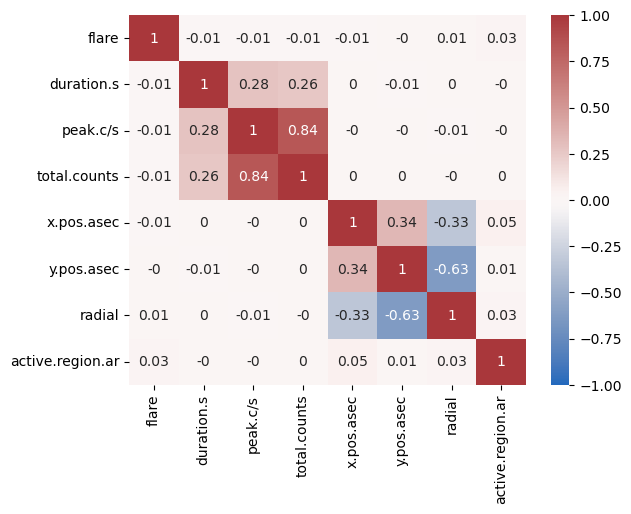

In [30]:
#A STUDY OF CORRELATION BETWEEN DIFFERENT PARAMETERS USING CORRELATION MATRIX
matrix = df.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

Removing records with certain flags: NS, SD, SS, SE, PS, Q12, Q11, Q10, Q9, Q8, Q7, Q6, Q5, Q4

In [31]:
'''Filtering data based on the energy range 3-6 KeV, flags and radial values. Filtering possible values
    which may be wrong or without any solar event '''

def filter_data(DATA,lwrong):
    ## filter 1: 3-6 kev
    lenght1 = len(DATA)
    DATA = DATA[DATA['energy.kev']!='3-6']
    lenght2 = len(DATA)
    if lenght1!=lenght2:
        print('filtering 3-6 kev energy range',lenght1,lenght2)


    # filter possible wrong values or without solar event
    for icod in lwrong:
        ## filter
        lenght1 = len(DATA)
        DATA = DATA[DATA['flag.1']!=icod]
        lenght2 = len(DATA)
        if lenght1!=lenght2:
            print('filtering %s'%icod,lenght1,lenght2)

        lenght1 = len(DATA)
        DATA = DATA[DATA['flag.2']!=icod]
        lenght2 = len(DATA)
        if lenght1!=lenght2:
            print('filtering %s'%icod,lenght1,lenght2)

        lenght1 = len(DATA)
        DATA = DATA[DATA['flag.3']!=icod]
        lenght2 = len(DATA)
        if lenght1!=lenght2:
            print('filtering %s'%icod,lenght1,lenght2)

        lenght1 = len(DATA)
        DATA = DATA[DATA['flag.4']!=icod]
        lenght2 = len(DATA)
        if lenght1!=lenght2:
            print('filtering %s'%icod,lenght1,lenght2)

        lenght1 = len(DATA)
        values = DATA['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if icod in i]
        DATA = DATA[~DATA['flag.5'].isin(lfilter)]
        lenght2 = len(DATA)
        if lenght1!=lenght2:
            print('filtering %s'%icod,lenght1,lenght2)

    return DATA

In [32]:

# filtering basic
lwrong = ['NS','SD','SS','SE','PS','Q12','Q11','Q10','Q9','Q8','Q7','Q6','Q5','Q4']
filtered_data = filter_data(df,lwrong)

filtering 3-6 kev energy range 113942 107606
filtering SD 107606 107570
filtering SD 107570 107476
filtering SS 107476 107469
filtering SS 107469 107441
filtering SE 107441 106999
filtering SE 106999 106035
filtering Q5 106035 105985
filtering Q4 105985 104718


In [33]:
filtered_data

,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN
1,2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN
2,2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN
3,2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN
4,2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,16121301,2016-12-13,15:40:12,15:41:14,15:43:36,204,24,8096,6-12,-336,260,425,0,A0,DR,EE,P1,PE Q3
113931,16121501,2016-12-15,03:26:36,03:30:06,03:38:32,716,136,76016,12-25,929,307,979,2617,A0,DR,P1,PE,Q2
113934,16122102,2016-12-21,16:16:40,16:16:42,16:16:48,8,24,368,6-12,914,-84,918,0,A0,DF,P1,PE,Q2
113940,16122702,2016-12-27,12:21:24,12:21:30,12:30:04,520,24,17336,6-12,326,326,461,0,A0,DF,DR,P1,PE Q3


In [34]:
#Splitting date to Month, Day and Year
# process date / time columns
def parse_date(sdatex,stimex):
    datex = datetime.strptime(sdatex, '%Y-%m-%d')
    timex = datetime.strptime(stimex, '%H:%M:%S')
    return datetime(datex.year,datex.month,datex.day,timex.hour,timex.minute,timex.second)

# Adding year, month, day, start date, peak date, end date and dropping earlier columns
filtered_data['dt.start'] = filtered_data[['start.date','start.time']].apply(lambda x: parse_date(x[0],x[1]), axis=1)
filtered_data['dt.peak'] = filtered_data[['start.date','peak']].apply(lambda x: parse_date(x[0],x[1]), axis=1)
filtered_data['dt.end'] = filtered_data[['start.date','end']].apply(lambda x: parse_date(x[0],x[1]), axis=1)

# clean columns
filtered_data.drop(['start.date','start.time','peak','end'], axis=1, inplace=True)

# add new columns
filtered_data['year'] = filtered_data['dt.start'].apply(lambda col: col.year)
filtered_data['month'] = filtered_data['dt.start'].apply(lambda col: col.month)
filtered_data['day'] = filtered_data['dt.start'].apply(lambda col: col.day)
filtered_data.drop(['dt.start','dt.peak','dt.end'], axis=1, inplace=True)

In [35]:
filtered_data

,flare,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,year,month,day
0,2021213,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN,2002,2,12
1,2021228,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN,2002,2,12
2,2021332,216,15,11448,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN,2002,2,13
3,2021308,244,20,17400,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN,2002,2,13
4,2021310,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2,2002,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,16121301,204,24,8096,6-12,-336,260,425,0,A0,DR,EE,P1,PE Q3,2016,12,13
113931,16121501,716,136,76016,12-25,929,307,979,2617,A0,DR,P1,PE,Q2,2016,12,15
113934,16122102,8,24,368,6-12,914,-84,918,0,A0,DF,P1,PE,Q2,2016,12,21
113940,16122702,520,24,17336,6-12,326,326,461,0,A0,DF,DR,P1,PE Q3,2016,12,27


In [36]:
#Drop flare, flag.1, flag.2, flag.3, flag.4, flag.5

# List of columns to be dropped
columns_to_drop = ['flare', 'flag.1', 'flag.2', 'flag.3', 'flag.4', 'flag.5','active.region.ar']

# Drop the specified columns
df_dropped = filtered_data.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
print("\nDataFrame after dropping columns:\n\n\n")
df_dropped


DataFrame after dropping columns:





,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,year,month,day
0,712,136,167304,12-25,592,-358,692,2002,2,12
1,288,7,9504,6-12,604,-341,694,2002,2,12
2,216,15,11448,6-12,-310,375,487,2002,2,13
3,244,20,17400,12-25,-277,378,469,2002,2,13
4,236,336,313392,25-50,-272,390,476,2002,2,13
...,...,...,...,...,...,...,...,...,...,...
113930,204,24,8096,6-12,-336,260,425,2016,12,13
113931,716,136,76016,12-25,929,307,979,2016,12,15
113934,8,24,368,6-12,914,-84,918,2016,12,21
113940,520,24,17336,6-12,326,326,461,2016,12,27


In [37]:
#Checking Null Values
print(df_dropped.isnull().sum())

# Check for null values in a specific column
print(df_dropped.isnull().sum())

# Display a summary of null values and data types
print(df_dropped.info())

duration.s      0
peak.c/s        0
total.counts    0
energy.kev      0
x.pos.asec      0
y.pos.asec      0
radial          0
year            0
month           0
day             0
dtype: int64
duration.s      0
peak.c/s        0
total.counts    0
energy.kev      0
x.pos.asec      0
y.pos.asec      0
radial          0
year            0
month           0
day             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104718 entries, 0 to 113941
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   duration.s    104718 non-null  int64 
 1   peak.c/s      104718 non-null  int64 
 2   total.counts  104718 non-null  int64 
 3   energy.kev    104718 non-null  object
 4   x.pos.asec    104718 non-null  int64 
 5   y.pos.asec    104718 non-null  int64 
 6   radial        104718 non-null  int64 
 7   year          104718 non-null  int64 
 8   month         104718 non-null  int64 
 9   day           104718 non-

In [38]:
#Checking Duplicates
duplicates =df_dropped.duplicated()

# Display rows with duplicate values
print(df_dropped[duplicates].sum())

duration.s      0.0
peak.c/s        0.0
total.counts    0.0
energy.kev      0.0
x.pos.asec      0.0
y.pos.asec      0.0
radial          0.0
year            0.0
month           0.0
day             0.0
dtype: float64


In [39]:
#Number of energy band classes after data cleaning
c=df_dropped.groupby("energy.kev")["energy.kev"].count()
print(c)

energy.kev
100-300         155
12-25         18417
25-50          1806
300-800           8
50-100          359
6-12          83970
7000-20000        1
800-7000          2
Name: energy.kev, dtype: int64


**Data Split: Training, Test and Unseen**

In [40]:
rare_categories = df_dropped['energy.kev'].value_counts()[df_dropped['energy.kev'].value_counts() == 1].index

# Create a DataFrame conaining only rows of rare categories
duplicate_df = df_dropped[df_dropped['energy.kev'].isin(rare_categories)].copy()

# Duplicate the records
df_dropped = pd.concat([df_dropped, duplicate_df], ignore_index=True)
y = df_dropped['energy.kev']

# Use StratifiedShuffleSplit to split the data
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(df_dropped, y):
    train_set = df_dropped.iloc[train_index]
    test_unseen_set = df_dropped.iloc[test_index]

# Further split the test_unseen_set into test_set and unseen_set
test_set, unseen_set = train_test_split(
    test_unseen_set,
    test_size=0.5,
    random_state=42,
    stratify=test_unseen_set['energy.kev']
)

# Display the shapes of the resulting sets
print("Shapes of the sets:")
print("Train set:", train_set.shape)
print("Test set:", test_set.shape)
print("Unseen set:", unseen_set.shape)

Shapes of the sets:
Train set: (78539, 10)
Test set: (13090, 10)
Unseen set: (13090, 10)


In [41]:
train_set.to_csv('train_set.csv', index=False)
test_set.to_csv('test_set.csv', index=False)
unseen_set.to_csv('unseen_set.csv', index=False)

# To run in Jupyter Notebook
# train_set.to_csv('../Dataset/train_set.csv', index=False)
# test_set.to_csv('../Dataset/test_set.csv', index=False)
# unseen_set.to_csv('../Dataset/unseen_set.csv', index=False)


**Pipeline and Model**

In [42]:
df1=pd.read_csv('/content/train_set.csv')
df2=pd.read_csv('/content/test_set.csv')

# To run in Jupyter Notebook
# df1=pd.read_csv("../Dataset/train_set.csv")
# df2=pd.read_csv('../Dataset/test_set.csv')


In [43]:
X_train=df1.drop('energy.kev', axis=1)
y_train=df1['energy.kev']
X_test=df2.drop('energy.kev', axis=1)
y_test=df2['energy.kev']
y_train.unique()

array(['6-12', '12-25', '25-50', '100-300', '50-100', '7000-20000',
       '800-7000', '300-800'], dtype=object)

In [44]:
#Encoding the target Column
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)

encoder = LabelEncoder()
target_categories = ['6-12', '12-25', '25-50', '100-300', '50-100', '300-800','800-7000','7000-20000']
encoder.fit(target_categories)
y_train=encoder.transform(y_train)
y_test=encoder.transform(y_test)

Model Selection

XGB classifier

In [45]:
# Create the XGBClassifier
xgb_classifier = XGBClassifier(random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance for XGBoost
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.05      0.08        19
           1       0.69      0.57      0.63      2302
           2       0.29      0.03      0.06       226
           3       0.00      0.00      0.00         1
           4       0.43      0.07      0.12        45
           5       0.91      0.96      0.93     10497

    accuracy                           0.87     13090
   macro avg       0.41      0.28      0.30     13090
weighted avg       0.85      0.87      0.86     13090



Random Forest

In [46]:
random_forest_classifier = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', random_forest_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance for Random Forest
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.11      0.15        19
           1       0.70      0.55      0.62      2302
           2       0.40      0.04      0.07       226
           3       0.00      0.00      0.00         1
           4       0.43      0.07      0.12        45
           5       0.90      0.96      0.93     10497

    accuracy                           0.87     13090
   macro avg       0.45      0.29      0.31     13090
weighted avg       0.85      0.87      0.86     13090



Decision Tree

In [47]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', decision_tree_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance for Decision Tree
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.16      0.14        19
           1       0.50      0.52      0.51      2302
           2       0.10      0.12      0.11       226
           3       0.00      0.00      0.00         1
           4       0.15      0.16      0.15        45
           5       0.90      0.89      0.90     10497

    accuracy                           0.81     13090
   macro avg       0.30      0.31      0.30     13090
weighted avg       0.81      0.81      0.81     13090



SVM

In [48]:
svm_classifier = SVC(kernel='rbf', random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', svm_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance for SVM
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.73      0.36      0.49      2302
           2       0.20      0.00      0.01       226
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        45
           5       0.87      0.99      0.92     10497

    accuracy                           0.85     13090
   macro avg       0.30      0.23      0.24     13090
weighted avg       0.83      0.85      0.83     13090



Hyperparameter Tuning for XGBoost

In [49]:
xgb_classifier = XGBClassifier(random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_classifier)
])


param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.1, 0.2, 0.4],
    'classifier__max_depth': [3, 4, 5]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'classifier__learning_rate': 0.4, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.25      0.11      0.15        19
           1       0.68      0.59      0.63      2302
           2       0.19      0.03      0.05       226
           3       0.00      0.00      0.00         1
           4       0.38      0.11      0.17        45
           5       0.91      0.96      0.93     10497

    accuracy                           0.87     13090
   macro avg       0.40      0.30      0.32     13090
weighted avg       0.85      0.87      0.86     13090



OverSampling and Undersampling

In [50]:
over = RandomOverSampler(sampling_strategy='not majority')

pipeline = imbPipeline([
     ('o', over),
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(learning_rate=0.4, max_depth=5, n_estimators=300))
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance with Oversampling
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.16      0.18        19
           1       0.55      0.72      0.62      2302
           2       0.15      0.17      0.16       226
           3       0.00      0.00      0.00         1
           4       0.20      0.09      0.12        45
           5       0.95      0.88      0.91     10497

    accuracy                           0.83     13090
   macro avg       0.34      0.34      0.33     13090
weighted avg       0.86      0.83      0.84     13090



In [51]:
over = RandomOverSampler(sampling_strategy='all')
pipeline = imbPipeline([
     ('o', over),
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(learning_rate=0.4, max_depth=5, n_estimators=300))
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance with Oversampling
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.16      0.19        19
           1       0.55      0.71      0.62      2302
           2       0.14      0.18      0.15       226
           3       0.00      0.00      0.00         1
           4       0.24      0.11      0.15        45
           5       0.95      0.88      0.91     10497

    accuracy                           0.83     13090
   macro avg       0.35      0.34      0.34     13090
weighted avg       0.86      0.83      0.84     13090



In [52]:
under = RandomUnderSampler(sampling_strategy='all')

pipeline = imbPipeline([
    ('u', under),
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(learning_rate=0.4, max_depth=5, n_estimators=300))
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance with Undersampling
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.11      0.01        19
           1       0.17      0.15      0.16      2302
           2       0.03      0.28      0.05       226
           3       0.00      0.00      0.00         1
           4       0.01      0.07      0.01        45
           5       0.86      0.21      0.34     10497
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.20     13090
   macro avg       0.13      0.10      0.07     13090
weighted avg       0.72      0.20      0.30     13090



In [ ]:
over = RandomOverSampler(sampling_strategy='not majority')
under = RandomUnderSampler(sampling_strategy='all')

pipeline = imbPipeline([
     ('o', over),('u', under),
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(learning_rate=0.4, max_depth=5, n_estimators=300))
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance with both
print(classification_report(y_test, y_pred))

Creating Pipeline after Hyperparameter Tuning

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', XGBClassifier(learning_rate=0.4, max_depth=5, n_estimators=300))
])

Checking Overfitting With Stratified K fold

In [ ]:
# Specify the scoring metric (F1 score)
scorer = make_scorer(f1_score, average='weighted')  # 'weighted' for multi-class classification

# Specify the number of folds for Stratified K-Fold cross-validation
n_folds = 5

# Instantiate StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation and calculate F1 scores
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_kfold, scoring=scorer)

# Print the F1 scores for each fold
for fold, f1_score_value in enumerate(f1_scores, 1):
    print(f"Fold {fold}: F1 Score = {f1_score_value:.4f}")

# Print the average F1 score across all folds
average_f1_score = f1_scores.mean()
print(f"\nAverage F1 Score across all folds: {average_f1_score:.4f}")

In [ ]:
pipeline.fit(X_train, y_train)


# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred))

Download Encoder and Model

In [ ]:
joblib.dump(pipeline, 'trained_pipeline.joblib')
joblib.dump(encoder, 'label_encoder.joblib')

# To run in Jupyter Notebook
# joblib.dump(pipeline, '../Dataset/trained_pipeline.joblib')
# joblib.dump(encoder, '../Dataset/label_encoder.joblib')

**Implement on Unseen data**

In [ ]:
df3=pd.read_csv('/content/unseen_set.csv')

# To run in Jupyter Notebook
# df3=pd.read_csv('../Dataset/unseen_set.csv')

x=df3.drop('energy.kev', axis=1)
y=df3['energy.kev']

In [ ]:
loaded_pipeline = joblib.load('/content/trained_pipeline.joblib')
loaded_encoder=joblib.load('/content/label_encoder.joblib')

# To run in Jupyter Notebook
# loaded_pipeline = joblib.load('../Dataset/trained_pipeline.joblib')
# loaded_encoder=joblib.load('../Dataset/label_encoder.joblib')

In [ ]:
y=loaded_encoder.transform(y)

In [ ]:
predictions = loaded_pipeline.predict(x)

In [ ]:
print(classification_report(y, predictions))